In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb

from scipy import stats

import shap 
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [87]:
housing_df = pd.read_csv("/Users/codexplore/Developer/repos/machine-learning-101/data/common_datasets/housing.csv")


## Feature Engineering

In [88]:
housing_df.loc[:,"rooms_per_house"] = housing_df["total_rooms"] / housing_df["households"]
housing_df.loc[:,"bedrooms_ratio"] = housing_df["total_bedrooms"] / housing_df["total_rooms"]
housing_df.loc[:,"people_per_house"] = housing_df["population"] / housing_df["households"]


In [89]:
housing_df = housing_df[~(housing_df["median_house_value"] > 500_000)]

In [90]:
housing_df.loc[:, "income_cat"] = pd.cut(housing_df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
X = housing_df.drop("median_house_value", axis=1)
y = housing_df["median_house_value"]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X["income_cat"], test_size=0.2, random_state=42)

In [92]:
X_train = X_train.drop(["income_cat"], axis=1)
X_test = X_test.drop(["income_cat"],axis=1)

In [93]:
def detect_column_type(df, target_col=None):
    if target_col:
        df = df.drop(target_col, axis=1)
    # Select numeric columns only
    numerical_cols = [cname for cname in df.select_dtypes(include=np.number).columns]
    # print(f"Numerical Features  : {numerical_cols}")
    # Categorical columns in the training data
    categorical_cols = [col for col in df.select_dtypes(exclude=np.number).columns]
    return numerical_cols, categorical_cols

def preprocess_data(X):
    # Convert categorical columns to 'category' dtype as required by lgb.Dataset
    _, categorical_cols = detect_column_type(X_train)
    for col in categorical_cols:
        X[col] = X[col].astype("category")
    return X

X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)


In [94]:
X_train.shape, X_test.shape

((15740, 12), (3935, 12))

## Model Training

### Baseline Model

In [107]:
train_dmatrix = xgb.DMatrix(data = X_train, label = y_train, enable_categorical=True) 
test_dmatrix = xgb.DMatrix(data = X_test, label = y_test, enable_categorical=True) 

# Define hyperparameters
params = {"objective": "reg:squarederror", 
          "tree_method": "hist" # gpu_hist to enable GPU 
}
num_boost_round = 5000
# Uses xgb.train instead of XGBRegressor, making it compatible with DMatrix.
xgb_r = xgb.train(params = params, 
                  dtrain = train_dmatrix,
                  num_boost_round = num_boost_round # for number of boosting rounds. Internally, XGBoost minimizes the loss function RMSE in small incremental rounds 
) 


In [108]:
# ===== 4. Make Predictions (Exponentiate back) =====
y_pred = xgb_r.predict(test_dmatrix)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 41927.761


### Using Validation Sets During Training

- `evals` create a list of two tuples that each contain two elements. The first element is the array for the model to evaluate, and the second is the array’s name.
- `early_stopping` forces XGBoost to watch the validation loss, and if it stops improving for a specified number of rounds, it automatically stops training.

In [ ]:
# evaluation on both train & test set
evals = [(train_dmatrix, "train"), (test_dmatrix, "validation")]

model = xgb.train(
   params=params,
   dtrain=train_dmatrix,
   num_boost_round=num_boost_round,
   evals=evals,
   verbose_eval=50, # print evaluation metrics every 50 rounds
   early_stopping_rounds=50 # automatically stop the training if validation loss doesn't improve for 50 consecutive rounds.
)

[0]	train-rmse:156914.52284	validation-rmse:155364.49225
[50]	train-rmse:30816.29389	validation-rmse:42134.59480
[100]	train-rmse:24176.59295	validation-rmse:41481.62299
[150]	train-rmse:19715.85129	validation-rmse:41416.29269
[195]	train-rmse:16953.19578	validation-rmse:41407.63596


### Cross-Validation
- `results` has the same number of rows as the number of boosting rounds. 
- Each row is the average of all splits for that round. So, to find the best score, we take the minimum of the `test-rmse-mean` column:

In [116]:
results = xgb.cv(
   params, train_dmatrix,
   num_boost_round=num_boost_round,
   metrics=["rmse", "mae"],
   nfold=5,
   early_stopping_rounds=50
)
results.tail()



,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
128,19723.360845,162.331555,14130.074884,119.288627,43689.473050,1238.838062,29212.368289,505.822445
129,19635.968284,172.135985,14069.335013,122.242267,43692.680846,1255.839873,29216.285860,514.573618
130,19546.333104,155.066561,14004.835658,108.174116,43689.280089,1263.792232,29217.298495,508.999273
131,19461.072834,140.748109,13941.617129,95.235622,43687.095173,1259.723305,29211.941716,511.978956
132,19391.516469,130.086481,13889.132241,97.849110,43679.604789,1247.111035,29202.894088,501.517487


In [75]:
# It has the same number of rows as the number of boosting rounds
# Each row is the average metrics of all splits (folds) for that round. 
best_num_boost_round = results.shape[0]
best_rmse = results['test-rmse-mean'].min()
print(best_num_boost_round, best_rmse) # 41602.84279031341

133 43679.604788510514


### Hyperparamter Tuning

In [ ]:
def tune_xgb_hyperparameters(train_dmatrix, n_trial=50, n_startup_trials=10, metrics="rmse"):
    """Hyperparameter tuning for XGBoost Regressor using Optuna and DMatrix."""

    # Default parameters (can be overridden by tuning)
    default_params = {
        "objective": "reg:squarederror",  # Regression objective
        "num_boost_round": 2000,
        "early_stopping_rounds": 10,
        "random_state": 2025,
        "n_jobs": -1,
        "verbosity": 0,
        "tree_method":"hist",  # gpu_hist this parameter means using the GPU when training our model to speedup the training process
        #"subsample": 0.8,
        #"learning_rate": 0.300000012,
        #"max_depth": 6,
        #"min_child_weight": 5,
    }

    def objective(trial):
        """Objective function for Optuna hyperparameter tuning."""
        tuning_params = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            # L2 regularization weight within a logarithmic scale (log=True)
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            # L1 regularization weight.
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            # sampling ratio for training data.
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            # sampling according to each tree.
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
            # minimum child weight, larger the term more conservative the tree.
            "min_child_weight" : trial.suggest_int("min_child_weight", 2, 10),
            # defines how selective algorithm is.
            "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log=True),
          "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        }
       
            

        

        params = {**default_params, **tuning_params}

        cv_results = xgb.cv(
            params=params,
            dtrain=train_dmatrix,
            num_boost_round=default_params["num_boost_round"],
            nfold=5,
            stratified=False,
            early_stopping_rounds=default_params["early_stopping_rounds"],
            metrics=metrics,
            seed=42,
            verbose_eval=500,
            callbacks=None,
        )

        # Get the fold with the **lowest test-rmse-mean**
        best_num_boost_round = len(cv_results)
        #print(cv_results)
        best_rmse = cv_results[f"test-{metrics}-mean"].min()

        # Save attributes to study
        print(f"🔹 Best number of boosting rounds: {best_num_boost_round}")
        trial.set_user_attr("best_num_boost_round", best_num_boost_round)
        

        return best_rmse # Optuna minimizes this metric

    def callback(study: optuna.study, trial: optuna.Trial):
        # Checks if the current trial is the best trial 
        if study.best_trial.number == trial.number:
            # Saves the best number of boosting rounds (best_num_boost_round) as a study attribute
            # This ensures that after all trials are completed, the study retains the best boosting round count.
            study.set_user_attr(
                key="best_num_boost_round",
                value=trial.user_attrs["best_num_boost_round"],
            )
    # Optuna study
    study = optuna.create_study(
        direction="minimize",  # We want to minimize RMSE
         # uses Bayesian Optimization to sample promising hyperparameter sets based on past trials.
        sampler=optuna.samplers.TPESampler(seed=42, 
                                           # The first n_startup_trials use random search (to explore different regions of the parameter space).
                                           n_startup_trials=n_startup_trials),
    )
    study.optimize(objective, n_trials=n_trial, callbacks=[callback])
    
    best_num_boost_round = study.user_attrs["best_num_boost_round"]

    # Extract best params
    best_params = study.best_params
    # this is to merge the default_params & best_params after the study
    for k, v in default_params.items():
        if k not in ("early_stopping_rounds", "verbosity"):
            # overwrite the best_param with default valeus
            best_params[k] = v
        if k == "num_boost_round":
            best_params["num_boost_round"] = best_num_boost_round
    print(f"✅ Final best number of boosting rounds: {best_num_boost_round}")

    return best_params

# Example usage (assuming X_train, y_train are defined)
best_xgb_params = tune_xgb_hyperparameters(train_dmatrix, n_trial=10, n_startup_trials=5, metrics="rmse")


[I 2025-04-24 23:06:26,139] A new study created in memory with name: no-name-84ebb33f-9417-4b82-9a0f-3e137945608d


[0]	train-rmse:215258.37958+615.45797	test-rmse:215249.74064+2489.88613
[500]	train-rmse:47008.35197+243.15738	test-rmse:49641.29492+1731.62814
[1000]	train-rmse:41834.50022+239.78166	test-rmse:45883.40342+1219.51765
[1500]	train-rmse:40024.81359+274.32256	test-rmse:45091.92580+1135.09678
[1999]	train-rmse:38619.37051+270.30824	test-rmse:44588.70343+1068.71905


[I 2025-04-24 23:06:51,149] Trial 0 finished with value: 44588.7034284112 and parameters: {'learning_rate': 0.005611516415334507, 'booster': 'gbtree', 'lambda': 1.77071686435378e-07, 'alpha': 1.7699302940633311e-07, 'subsample': 0.10517943155978948, 'colsample_bytree': 0.8929409166199482, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 1.4610865886287176e-08, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 44588.7034284112.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:215896.32973+616.43520	test-rmse:215883.18179+2492.23869


[W 2025-04-24 23:11:17,347] Trial 1 failed with parameters: {'learning_rate': 0.0026587543983272706, 'booster': 'dart', 'lambda': 0.00015777981883364995, 'alpha': 2.854697857797175e-05, 'subsample': 0.3266676831881398, 'colsample_bytree': 0.6894823157779036, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 8.528933855762809e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0007250347382396634, 'skip_drop': 2.3130924416844053e-07} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/codexplore/miniforge3/envs/ml_env/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/10/n2pk9skj29l6tsds0vmch5lm0000gn/T/ipykernel_82633/751178439.py", line 50, in objective
    cv_results = xgb.cv(
                 ^^^^^^^
  File "/Users/codexplore/miniforge3/envs/ml_env/lib/python3.11/site-p

KeyboardInterrupt: 

In [77]:
best_xgb_params

{'reg_alpha': 0.00019935702522627045,
 'reg_lambda': 0.7660387097579393,
 'objective': 'reg:squarederror',
 'num_boost_round': 137,
 'random_state': 42,
 'n_jobs': -1}

In [78]:
final_model = xgb.train(params=best_xgb_params, dtrain = train_dmatrix)
y_pred = final_model.predict(test_dmatrix)
print(root_mean_squared_error(y_test, y_pred))

48480.29749508101


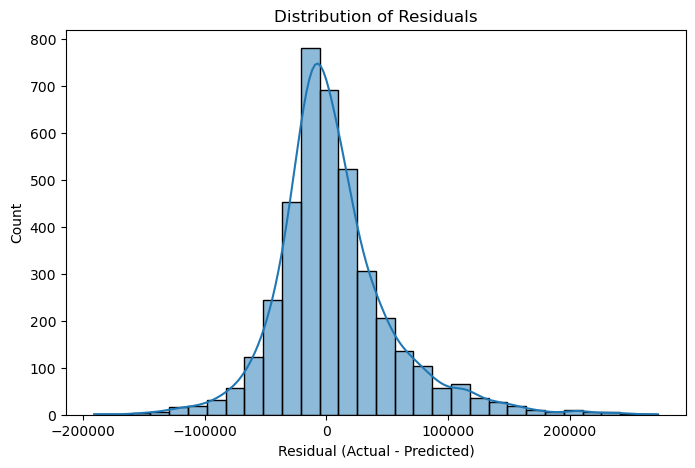

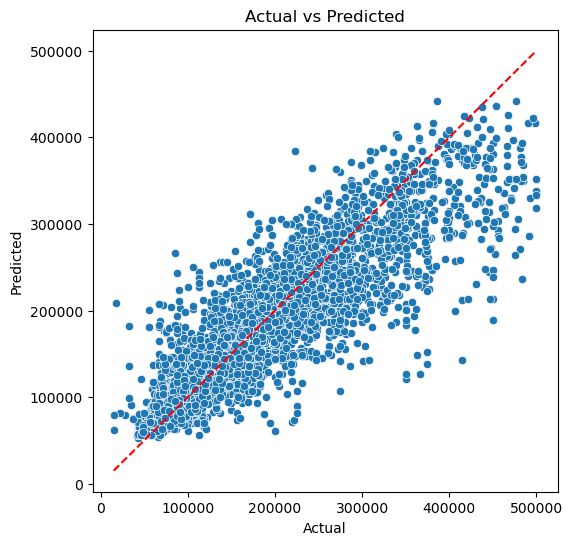

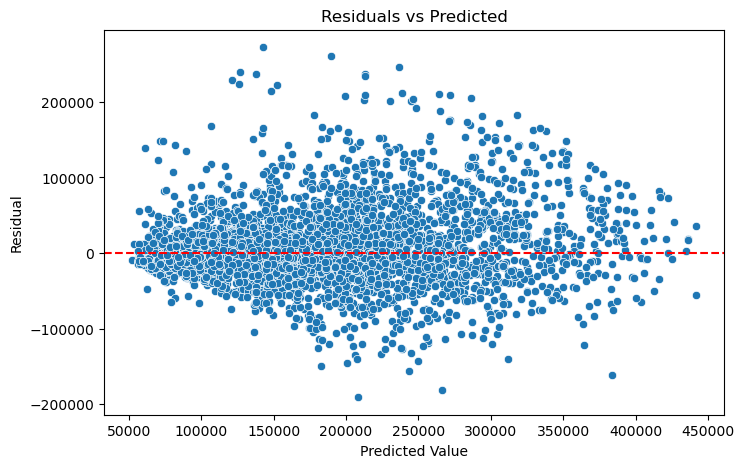

Top 10 worst predictions:
         Actual      Predicted       Residual  Absolute Residual  \
6410   414800.0  142430.031250  272369.968750      272369.968750   
4623   450000.0  189388.843750  260611.156250      260611.156250   
140    483300.0  236841.343750  246458.656250      246458.656250   
12429  366700.0  126472.023438  240227.976562      240227.976562   
16835  450000.0  212815.703125  237184.296875      237184.296875   
18498  374600.0  137958.328125  236641.671875      236641.671875   
6445   447100.0  213093.796875  234006.203125      234006.203125   
7262   350000.0  121112.312500  228887.687500      228887.687500   
458    350000.0  126357.015625  223642.984375      223642.984375   
9192   375000.0  152383.828125  222616.171875      222616.171875   

       Percent Error  
6410        0.656630  
4623        0.579136  
140         0.509950  
12429       0.655108  
16835       0.527076  
18498       0.631718  
6445        0.523387  
7262        0.653965  
458         0.6389

In [79]:

# y_test: ground truth, y_pred: model prediction
residuals = y_test - y_pred
abs_residuals = np.abs(residuals)
percent_error = abs_residuals / np.abs(y_test)

error_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Residual": residuals,
    "Absolute Residual": abs_residuals,
    "Percent Error": percent_error
})

# 1. Residual Distribution
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# 2. Predicted vs Actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

# 3. Residual vs Predicted (look for heteroscedasticity)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.show()

# 4. Identify worst predictions
worst_cases = error_df.sort_values(by="Absolute Residual", ascending=False).head(10)
print("Top 10 worst predictions:")
print(worst_cases)


In [80]:
# These are true outliers that might not follow the pattern the model has learned.
X_test.loc[5887, :]

longitude               -118.33
latitude                  34.15
housing_median_age         39.0
total_rooms               493.0
total_bedrooms            168.0
population                259.0
households                138.0
median_income            2.3667
ocean_proximity       <1H OCEAN
rooms_per_house        3.572464
bedrooms_ratio         0.340771
people_per_house       1.876812
Name: 5887, dtype: object

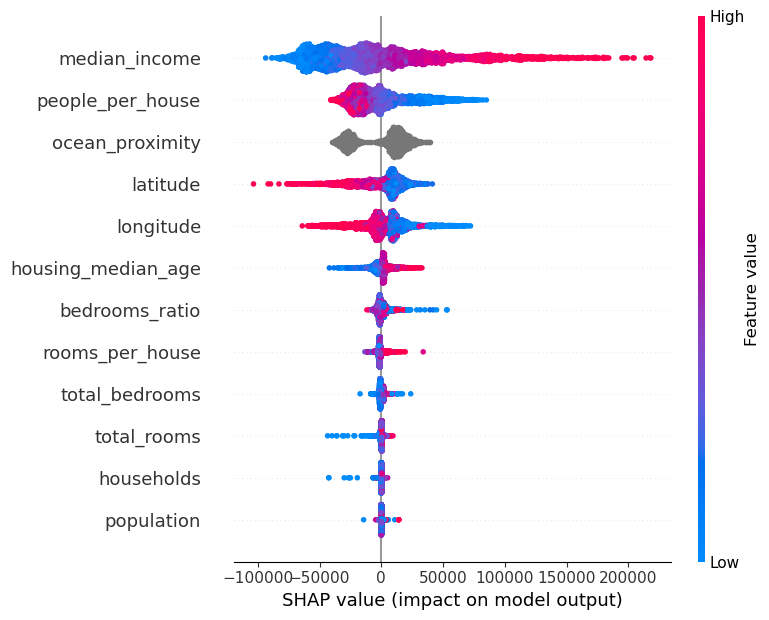

In [81]:
# Explain the model's predictions using SHAP
explainer = shap.Explainer(final_model)
shap_values = explainer(test_dmatrix)

shap.summary_plot(shap_values, X_test)


In [82]:
# compute a 95% confidence interval for the generalization error using scipy.stats.bootstrap().
# Defines a helper function to compute RMSE from squared errors.
def rmse_func(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (y_pred - y_test) ** 2
# It performs bootstrap resampling on the squared_errors data (i.e., repeatedly samples with replacement).
# Each resample is used to compute an RMSE via rmse_func function.
boot_result = stats.bootstrap([squared_errors], rmse_func,
                              confidence_level=confidence, random_state=42)
# After many iterations (by default, 9999), it calculates the confidence interval of the RMSE distribution.
rmse_lower, rmse_upper = boot_result.confidence_interval

print(f"95% CI for RMSE: [{rmse_lower:.4f}, {rmse_upper:.4f}]")


95% CI for RMSE: [46776.2654, 50336.1104]


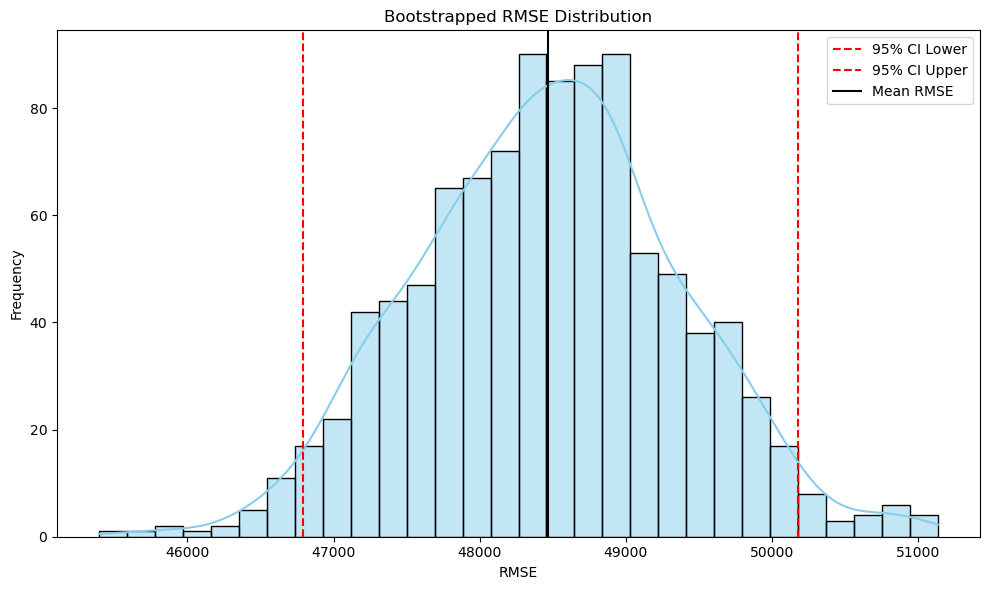

In [83]:

n_iterations = 1000

rng = np.random.default_rng(seed=42)

rmse_samples = []

n = len(squared_errors)
for _ in range(n_iterations):
    # Sample with replacement
    sample = rng.choice(squared_errors, size=n, replace=True)
    rmse_sample = rmse_func(sample)
    rmse_samples.append(rmse_sample)

# Compute confidence interval
lower_bound = np.percentile(rmse_samples, (1 - confidence) / 2 * 100)
upper_bound = np.percentile(rmse_samples, (1 + confidence) / 2 * 100)

# 📈 Plotting the RMSE distribution
plt.figure(figsize=(10, 6))
sns.histplot(rmse_samples, bins=30, kde=True, color="skyblue")
plt.axvline(lower_bound, color="red", linestyle="--", label=f"{int(confidence*100)}% CI Lower")
plt.axvline(upper_bound, color="red", linestyle="--", label=f"{int(confidence*100)}% CI Upper")
plt.axvline(np.mean(rmse_samples), color="black", linestyle="-", label="Mean RMSE")
plt.title("Bootstrapped RMSE Distribution")
plt.xlabel("RMSE")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
